In [1]:
%matplotlib inline
# import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
from scipy import ndimage
from tqdm import tqdm
import time
import numpy as np
import cupy as cp

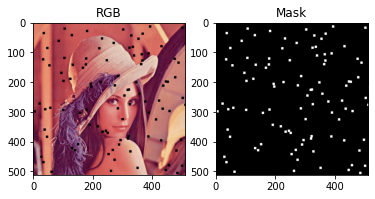

In [2]:
# origin_path = '../data/inpainting/image1.jpg.png'
# image_path = '../data/Lenna/color_maskV4/lena_color_defect.png'
# mask_path = '../data/Lenna/color_maskV4/lena_color_mask.png'
origin_path = '../data/kodim23/kodim23.png'
image_path = '../data/kodim23/kodim23_defect.png'
mask_path = '../data/kodim23/kodim23_mask.png'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.THRESH_BINARY)
_, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
mask//=255

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(image)
ax1.title.set_text("RGB")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(mask, cmap='gray')
ax2.title.set_text("Mask")
plt.show()

In [3]:
height, width = image.shape[:2]
patch_size = (5, 5)

confidence = (1-mask).astype("float32")
data = np.zeros(shape=(height, width))

working_image = np.copy(image)
working_mask = np.copy(mask)

In [4]:
def _get_front():
    _front = np.array(scipy.ndimage.laplace(working_mask)>0, np.uint8)   
    return _front

In [5]:
def _patch_data(source, patch):
    try:
        return source[
            int(patch[0][0]):int(patch[0][1]+1),
            int(patch[1][0]):int(patch[1][1]+1)
        ]
    except: 
        print("[ERROR] _patch_data: patch", patch[0][0], "+", patch[0][1]+1, ",", patch[1][0], "+", patch[1][1]+1)

def _patch_shape(patch):
    return 1+patch[0][1]-patch[0][0], 1+patch[1][1]-patch[1][0]
    
def _get_patch(point, showPatch = False, padding = 0):
    patch = [
        [## Y
            max(0, point[0]-(patch_size[0]-1)//2),
            min(point[0]+(patch_size[0]-1)//2, height-1)
        ],
        [## X
            max(0, point[1]-(patch_size[1]-1)//2),
            min(point[1]+(patch_size[1]-1)//2, width-1)
        ]
    ]

    patch[0][0]-=(patch_size[0]-1-patch[0][1]+patch[0][0]) if patch[0][1] == height-1 else 0
    patch[0][1]+=(patch_size[0]-1-patch[0][1]+patch[0][0]) if patch[0][0] == 0 else 0
    patch[1][0]-=(patch_size[1]-1-patch[1][1]+patch[1][0]) if patch[1][1] == width-1 else 0
    patch[1][1]+=(patch_size[1]-1-patch[1][1]+patch[1][0]) if patch[1][0] == 0 else 0
    
    if showPatch:
        show_patch = [
            [## Y
                max(0, point[0]-(patch_size[0]-1)//2-padding),
                min(point[0]+(patch_size[0]-1)//2+padding, height-1)
            ],
            [## X
                max(0, point[1]-(patch_size[1]-1)//2-padding),
                min(point[1]+(patch_size[1]-1)//2+padding, width-1)
            ]
        ]
        print("[MESSAGE] _get_patch, point: ", point)
        print("patch[{}:{}, {}:{}]".format(patch[0][0], patch[0][1], patch[1][0], patch[1][1]))
        print("show_patch[{}:{}, {}:{}]".format(show_patch[0][0], show_patch[0][1], show_patch[1][0], show_patch[1][1]))
        patch_fronts = [
            (patch[0][0]-show_patch[0][0], patch[1][0]-show_patch[1][0]), 
            (patch[0][0]-show_patch[0][0], show_patch[1][1]-patch[1][0]), 
            (show_patch[0][1]-patch[0][0], show_patch[1][1]-patch[1][0]), 
            (show_patch[0][1]-patch[0][0], patch[1][0]-show_patch[1][0]), 
            (patch[0][0]-show_patch[0][0], patch[1][0]-show_patch[1][0])
        ]
        print("patch_fronts", patch_fronts)
        plt.imshow(_patch_data(image, show_patch), alpha=1)
        plt.imshow(_patch_data(front, show_patch), alpha=0.4)
        plt.plot([p[1] for p in patch_fronts], [p[0] for p in patch_fronts], "-r")
        plt.plot(
            point[0]-show_patch[0][0], point[1]-show_patch[1][0],
            marker='.', 
            markersize=np.sqrt(np.sqrt(patch[0][1]-patch[0][0])*(patch[1][1]-patch[1][0])), 
            color='b'
        )
        plt.show()
    return patch

In [6]:
def _get_patch_Show(point, showPatch = False, padding = 0):
    patch = [
        [## Y
            max(0, point[0]-(patch_size[0]-1)//2),
            min(point[0]+(patch_size[0]-1)//2, height-1)
        ],
        [## X
            max(0, point[1]-(patch_size[1]-1)//2),
            min(point[1]+(patch_size[1]-1)//2, width-1)
        ]
    ]
    show_patch = [
        [## Y
            max(0, point[0]-(patch_size[0]-1)//2-padding),
            min(point[0]+(patch_size[0]-1)//2+padding, height-1)
        ],
        [## X
            max(0, point[1]-(patch_size[1]-1)//2-padding),
            min(point[1]+(patch_size[1]-1)//2+padding, width-1)
        ]
    ]
    if showPatch:
        if DEBUG:
            print("[MESSAGE] _get_patch, point: ", point)
            print("patch[{}:{}, {}:{}]".format(patch[0][0], patch[0][1], patch[1][0], patch[1][1]))
            print("show_patch[{}:{}, {}:{}]".format(show_patch[0][0], show_patch[0][1], show_patch[1][0], show_patch[1][1]))
        patch_fronts = [
            (patch[0][0]-show_patch[0][0], patch[1][0]-show_patch[1][0]), 
            (patch[0][0]-show_patch[0][0], show_patch[1][1]-patch[1][0]), 
            (show_patch[0][1]-patch[0][0], show_patch[1][1]-patch[1][0]), 
            (show_patch[0][1]-patch[0][0], patch[1][0]-show_patch[1][0]), 
            (patch[0][0]-show_patch[0][0], patch[1][0]-show_patch[1][0])
        ]
        print("patch_fronts", patch_fronts)
        plt.imshow(_patch_data(image, show_patch), alpha=1)
        plt.imshow(_patch_data(front, show_patch), alpha=0.4)
        plt.plot([p[1] for p in patch_fronts], [p[0] for p in patch_fronts], "-r")
        plt.plot(
            point[0]-show_patch[0][0], point[1]-show_patch[1][0],
            marker='.', 
            markersize=np.sqrt(np.sqrt(patch[0][1]-patch[0][0])*(patch[1][1]-patch[1][0])), 
            color='b'
        )
        plt.show()
    return show_patch

def show_point_patch(point, background=image, show_point=True):
    if DEBUG:
        print("[MESSAGE] show_point_patch")
    patch = _get_patch(point)
    # print(patch[0][0], patch[0][1])
    # print(patch[1][0], patch[1][1])
    plot_list = [
        (patch[0][0], patch[1][0]), 
        (patch[0][0], patch[1][1]), 
        (patch[0][1], patch[1][1]), 
        (patch[0][1], patch[1][0]), 
        (patch[0][0], patch[1][0])
    ]
    # print("plot", plot_list)
    plt.imshow(background)
    plt.imshow(front, alpha=0.4)
    plt.plot([p[1] for p in plot_list], [p[0] for p in plot_list], "-r")
    if show_point:
        plt.plot(point[1], point[0], marker='.', markersize=np.sqrt(np.sqrt(patch[0][1]-patch[0][0])*(patch[1][1]-patch[1][0]))/4, color='b')
    # plt.title(title)
    plt.show()

def _show_patch(source, patch, show_point=False, padding = 0, ax = None, ax_title = ""):
    if ax is None:
        fig, ax = plt.subplots()
    if DEBUG:
        print("[MESSAGE] show_patch")
    if padding > 0:
        show_patch = [
            [## Y
                max(0, patch[0][0]-padding),
                min(patch[0][1]+padding, height-1)
            ],
            [## X
                max(0, patch[1][0]-padding),
                min(patch[1][1]+padding, width-1)
            ]
        ]
        patch_fronts = [
            (patch[0][0]-show_patch[0][0], patch[1][0]-show_patch[1][0]), 
            (patch[0][0]-show_patch[0][0], show_patch[1][1]-patch[1][0]), 
            (show_patch[0][1]-patch[0][0], show_patch[1][1]-patch[1][0]), 
            (show_patch[0][1]-patch[0][0], patch[1][0]-show_patch[1][0]), 
            (patch[0][0]-show_patch[0][0], patch[1][0]-show_patch[1][0])
        ]
        if DEBUG:
            print("[MESSAGE] _get_patch")
            print("patch[{}:{}, {}:{}]".format(patch[0][0], patch[0][1], patch[1][0], patch[1][1]))
            print("show_patch[{}:{}, {}:{}]".format(show_patch[0][0], show_patch[0][1], show_patch[1][0], show_patch[1][1]))
            print("patch_fronts", patch_fronts)
        ax.set_title(ax_title+", padding={}".format(padding), fontproperties="Noto Sans TC", fontsize=25)
        ax.imshow(_patch_data(source, show_patch), alpha=1)
        ax.imshow(_patch_data(front, show_patch), alpha=0.4)
        ax.plot([p[1] for p in patch_fronts], [p[0] for p in patch_fronts], "-r")
        if ax is None:
            plt.show()

        return ax
    else:
        ax.set_title(ax_title, fontproperties="Noto Sans TC", fontsize=25)
        ax.imshow(source)
        ax.imshow(front, alpha=0.4)
        plot_list = [(patch[0][0], patch[1][0]), (patch[0][0], patch[1][1]), (patch[0][1], patch[1][1]), (patch[0][1], patch[1][0]), (patch[0][0], patch[1][0])]
        ax.plot([p[1] for p in plot_list], [p[0] for p in plot_list], "-r")
        if show_point:
            ax.plot(
                (patch[1][1]+patch[1][0])/2, (patch[0][1]+patch[0][0])/2, 
                marker='.', 
                markersize=np.sqrt(np.sqrt(patch[0][1]-patch[0][0])*(patch[1][1]-patch[1][0])), 
                color='b'
            )
        if ax is None:
            plt.show()

        return ax

In [7]:
def _get_confidence(point):
    patch = _get_patch(point)
    patch_confidence = _patch_data(confidence, patch)
    return patch_confidence.sum() / (patch_confidence.shape[0]*patch_confidence.shape[1])

def _update_confidence(confidence):
    new_confidence = np.copy(confidence)
    for point in front_positions:
        new_confidence[point[0], point[1]] = _get_confidence(point)
    confidence = new_confidence
    return confidence

In [8]:
from skimage import io, color

def _update_data(working_image, working_mask, front):
    normal = _calc_normal_matrix(working_mask)
    
    gradient = _calc_gradient_matrix(working_image, working_mask, front)
    
    normal_gradient = normal*gradient
    data = np.sqrt(normal_gradient[:, :, 0]**2 + normal_gradient[:, :, 1]**2) + 0.001

    return data

def _calc_normal_matrix(working_mask):
    x_kernal = np.array([
        [.25, 0, -.25],
        [.5, 0, -.5],
        [.25, 0, -.25],
    ])
    y_kernal = np.array([
        [-.25, -.5, -.25],
        [0, 0, 0],
        [.25, .5, .25],
    ])
    
    x_normal = scipy.ndimage.convolve(working_mask.astype('float64'), x_kernal)
    y_normal = scipy.ndimage.convolve(working_mask.astype('float64'), y_kernal)
    normal = np.dstack((x_normal, y_normal))
    
    height, width = normal.shape[:2]
    norm = np.sqrt(y_normal**2 + x_normal**2) \
        .reshape(height, width, 1) \
        .repeat(2, axis=2)
    norm[norm == 0] = 1
    unit_normal = normal/norm
    return unit_normal

def _calc_gradient_matrix(working_image, working_mask, front):
    height, width = working_image.shape[:2]    
    gray_image = color.rgb2gray(working_image)
    gray_image[working_mask == 1] = None
    gradient = np.nan_to_num(np.array(np.gradient(gray_image)))
    
    gradient_val = np.sqrt(gradient[0]**2 + gradient[1]**2)
    max_gradient = np.zeros([height, width, 2])
    
    front_positions = np.argwhere(front == 1)
    for point in front_positions:
        patch = _get_patch(point)
        patch_y_gradient = _patch_data(gradient[0], patch)
        patch_x_gradient = _patch_data(gradient[1], patch)
        patch_gradient_val = _patch_data(gradient_val, patch)
        
        patch_max_pos = np.unravel_index(
            patch_gradient_val.argmax(),
            patch_gradient_val.shape
        )
        
        max_gradient[point[0], point[1], 0] = patch_y_gradient[patch_max_pos]
        max_gradient[point[0], point[1], 1] = patch_x_gradient[patch_max_pos]
    
    return max_gradient

In [9]:
def _update_priority(working_image, working_mask, confidence, front):
    confidence = _update_confidence(confidence)

    data = _update_data(working_image, working_mask, front)

    priority = confidence*data*front
    return priority

In [10]:
def _find_highest_priority_pixel(priority):
    point = np.unravel_index(
        priority.argmax(),
        priority.shape
    )
    return point

In [11]:
## @staticmethod
def _to_rgb(image):
    height, width = image.shape
    return image.reshape(height, width, 1).repeat(3, axis=2)

# eligible patch list
def ELIG_patch_list(source, patch_list):
    eligible_patch_list = np.array([
        patch
        for patch in patch_list
        if _patch_data(source, patch).sum() == 0
    ], dtype=np.int64)
    return eligible_patch_list

def _patch_list(height, width, patch_height, patch_width, base_height=0, base_width=0):
    for y in range(base_height, base_height+height-patch_height+1):
        for x in range(base_width, base_width+width-patch_width+1):
            yield [y, y+patch_height-1], [x, x+patch_width-1]

In [12]:
def _update_image(target_pixel, source_patch):
    target_patch = _get_patch(target_pixel)
    pixels_positions = np.argwhere(
        _patch_data(working_mask, target_patch) == 1
    ) + [target_patch[0][0], target_patch[1][0]]
    patch_confidences = confidence[target_pixel[0], target_pixel[1]]
    for point in pixels_positions:
        confidence[point[0], point[1]] = patch_confidences
    mask = _patch_data(working_mask, target_patch)
    rgb_mask = _to_rgb(mask)
    source_data = _patch_data(working_image, source_patch)
    target_data = _patch_data(working_image, target_patch)

    new_data = source_data*rgb_mask + target_data*(1-rgb_mask)

    _copy_to_patch(
        working_image,
        target_patch,
        new_data
    )

    _copy_to_patch(
        working_mask,
        target_patch,
        0
    )

def _copy_to_patch(dest, dest_patch, data):
    dest[
        dest_patch[0][0]:dest_patch[0][1]+1,
        dest_patch[1][0]:dest_patch[1][1]+1
    ] = data

In [13]:
## TODO: 解決重複的垃圾區塊問題
## 參考資料: https://www.cnpython.com/qa/228231

def update_elig(lab_image, associate_patch, patchs, patchs_data):
    elig = np.array(ELIG_patch_list(
        working_mask,
        _patch_list(
            associate_patch[0][1] - associate_patch[0][0], 
            associate_patch[1][1] - associate_patch[1][0], 
            patch_size[0], patch_size[1], 
            base_height=associate_patch[0][0]+1, 
            base_width=associate_patch[1][0]+1
        )
    ))

    if elig.size > 0:
        patchs = cp.concatenate([cp.array(elig), patchs])
        patchs_data = cp.concatenate([cp.array([_patch_data(lab_image, patch) for patch in elig]), patchs_data])
    return patchs, patchs_data

    # # DEBUG
    # # print("elig:", elig.shape, elig)
    # return elig, np.array([_patch_data(lab_image, patch) for patch in elig])


In [14]:
def isFinished(working_mask):
    return working_mask.sum() == 0

Iter: 1, sRuntime: 5.090259075164795, nowMask: 6284
Iter: 2, sRuntime: 0.34707188606262207, nowMask: 6278
Iter: 3, sRuntime: 0.36107397079467773, nowMask: 6272
Iter: 4, sRuntime: 0.35005998611450195, nowMask: 6266
Iter: 5, sRuntime: 0.35935163497924805, nowMask: 6260
Iter: 6, sRuntime: 0.3429596424102783, nowMask: 6254
Iter: 7, sRuntime: 0.3480689525604248, nowMask: 6248
Iter: 8, sRuntime: 0.36602139472961426, nowMask: 6242
Iter: 9, sRuntime: 0.36104416847229004, nowMask: 6236
Iter: 10, sRuntime: 0.34114909172058105, nowMask: 6230
Iter: 11, sRuntime: 0.34613609313964844, nowMask: 6224
Iter: 12, sRuntime: 0.347135066986084, nowMask: 6218
Iter: 13, sRuntime: 0.34554219245910645, nowMask: 6212
Iter: 14, sRuntime: 0.352888822555542, nowMask: 6206
Iter: 15, sRuntime: 0.34212327003479004, nowMask: 6200
Iter: 16, sRuntime: 0.3346107006072998, nowMask: 6194
Iter: 17, sRuntime: 0.35057711601257324, nowMask: 6188
Iter: 18, sRuntime: 0.35110020637512207, nowMask: 6182
Iter: 19, sRuntime: 0.343042

Text(0.5, 0.98, 'Iter: 1183, Runtime: 332.74470806121826s, Total_Mask: 0')

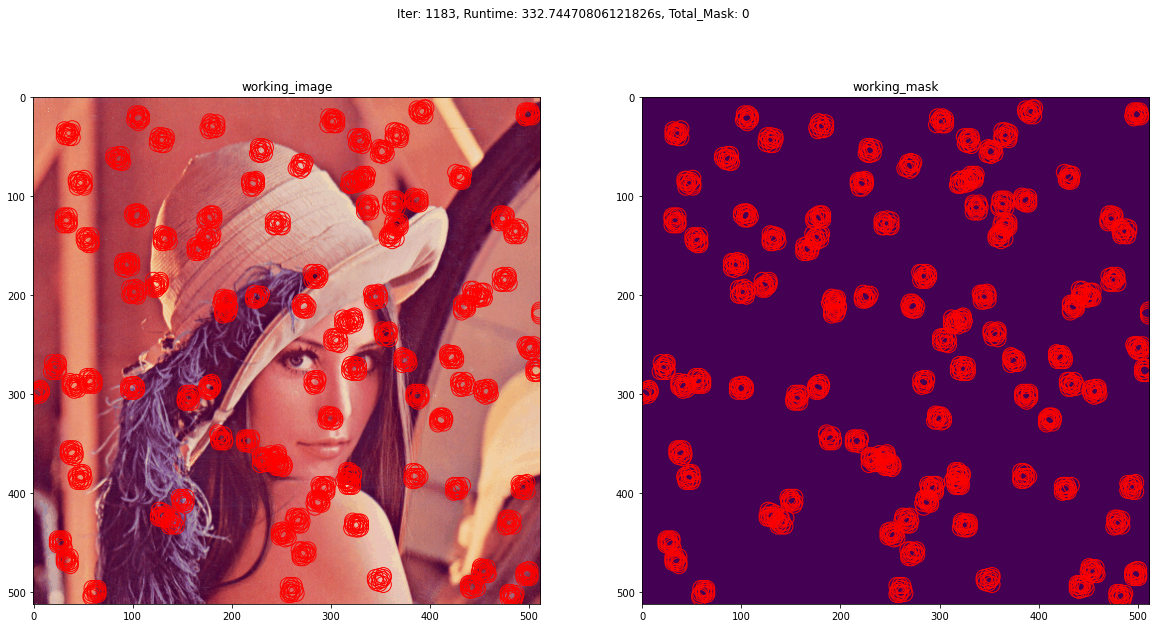

In [15]:
from celluloid import Camera

try:
    fig
    axs
    camera
    itera
    timer
except NameError:
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    camera = Camera(fig)
    itera = 0
    timer = []

while(True):
    mask_sum = working_mask.sum()
    if mask_sum == 0:
        break;
    
    start_time = time.time()

    ## 修補的外框
    front = _get_front()
    front_positions = np.argwhere(front == 1)

    ## 尋找最高優先度的修補點
    priority = _update_priority(
        working_image, working_mask, confidence, front
    )
    target_pixel = _find_highest_priority_pixel(priority)

    ## 取得被修補區塊範圍(patch)
    target_patch = _get_patch(target_pixel)

    ## 目前image的lab圖
    lab_image = color.rgb2lab(working_image)

    ## 被修補區塊中不該被修補的部分(陣列中為1的部分)
    mask = 1-_patch_data(working_mask, target_patch)
    ### GPU
    rgb_mask = cp.array(_to_rgb(mask))

    ## 整張圖片中被考慮替換掉 被修補區塊的 範圍list及lab範圍值
    try:
        source_patchs
    except NameError:
        source_patchs = ELIG_patch_list(working_mask, _patch_list(height, width, patch_size[0], patch_size[1]))
        lab_image_source_patchs_data = [_patch_data(lab_image, patch) for patch in source_patchs]
        ### GPU
        source_patchs = cp.array(source_patchs)
        lab_image_source_patchs_data = cp.array(lab_image_source_patchs_data)

    ## 被修補區塊的lab範圍值 
    ### GPU
    target_patch_data = cp.array(_patch_data(lab_image, target_patch))*rgb_mask

    

    ## 計算值差
    squared_distance = ((target_patch_data - lab_image_source_patchs_data*rgb_mask)**2).sum(axis=(3, 2, 1))
    euclidean_distance = np.sqrt(
        (target_patch[0][0] - source_patchs[:, 0, 0])**2 +
        (target_patch[1][0] - source_patchs[:, 1, 0])**2
    )
    diff = squared_distance + euclidean_distance

    ## 與被修補區塊的lab範圍值的差值最小 以及 距離最近的範圍
    mix_source_index = diff.argmin()
    source_patch = source_patchs[mix_source_index]

    # 帶修補區域中 未來會會加入source_patchs的範圍
    ## 帶修補區域中要被替換掉的值索引
    associate_pos = np.argwhere(
        _patch_data(working_mask, target_patch) == 1
    )
    ## 最左上的點
    min_patch_pos = min(associate_pos[:, 0])+target_patch[0][0], min(associate_pos[:, 1])+target_patch[1][0]
    ## 會影響到同樣patch_size的範圍，這裡為修補過後應該加入的範圍
    associate_patch = [
        [max(min_patch_pos[0]-patch_size[0]+1, 0), min_patch_pos[0]+(max(associate_pos[:, 0])-min(associate_pos[:, 0]))],
        [max(min_patch_pos[1]-patch_size[1]+1, 0), min_patch_pos[1]+(max(associate_pos[:, 1])-min(associate_pos[:, 1]))]
    ]

    ## 開始對 被修補區塊 進行替換
    _update_image(target_pixel, source_patch)

    ## 把因為修補後所產生的那些 也該被考量在與target_patch範圍 加入倒source_patchs 及 lab_image_source_patchs_data
    source_patchs, lab_image_source_patchs_data = update_elig(lab_image, associate_patch, source_patchs, lab_image_source_patchs_data)

    ## 畫面紀錄
    end_time = time.time()
    timer.append(end_time-start_time)
    itera += 1
    print("Iter: {}, sRuntime: {}, nowMask: {}".format(itera, end_time-start_time, mask_sum))
    
    axs[0].imshow(working_image)
    axs[0].set_title('working_image')
    axs[0].scatter(target_pixel[1], target_pixel[0], facecolors='none', s=(height+width)//4, marker='o', edgecolors='r')
    
    axs[1].imshow(working_mask)
    axs[1].set_title('working_mask')
    axs[1].scatter(target_pixel[1], target_pixel[0], facecolors='none', s=(height+width)//4, marker='o', edgecolors='r')
    camera.snap()
    # axs[0].cla()
    # axs[1].cla()

fig.suptitle("Iter: {}, Runtime: {}s, Total_Mask: {}".format(itera, sum(timer), mask_sum))
# plt.imshow(working_image)
# plt.title = "result"

In [16]:
source_patchs.shape, lab_image_source_patchs_data.shape

((245052, 2, 2), (245052, 5, 5, 3))

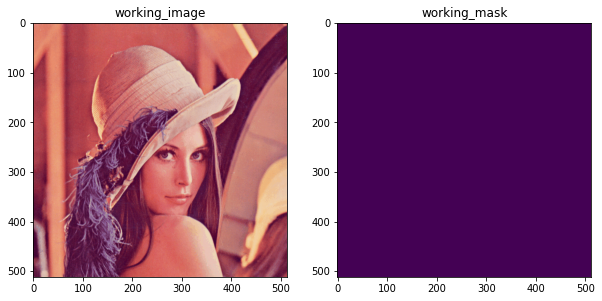

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(working_image)
axs[0].set_title('working_image')
axs[1].imshow(working_mask)
axs[1].set_title('working_mask')
plt.show()

In [18]:
import os
basename = os.path.basename(image_path)
file_name = os.path.splitext(basename)[0]
file_secondName = os.path.splitext(basename)[1]
print(file_name, file_secondName)

lena_color_defect .png


In [20]:
## 總運算修補時間(s)
sum(timer), sum(timer)/len(timer)

(332.74470806121826, 0.28127194257076776)

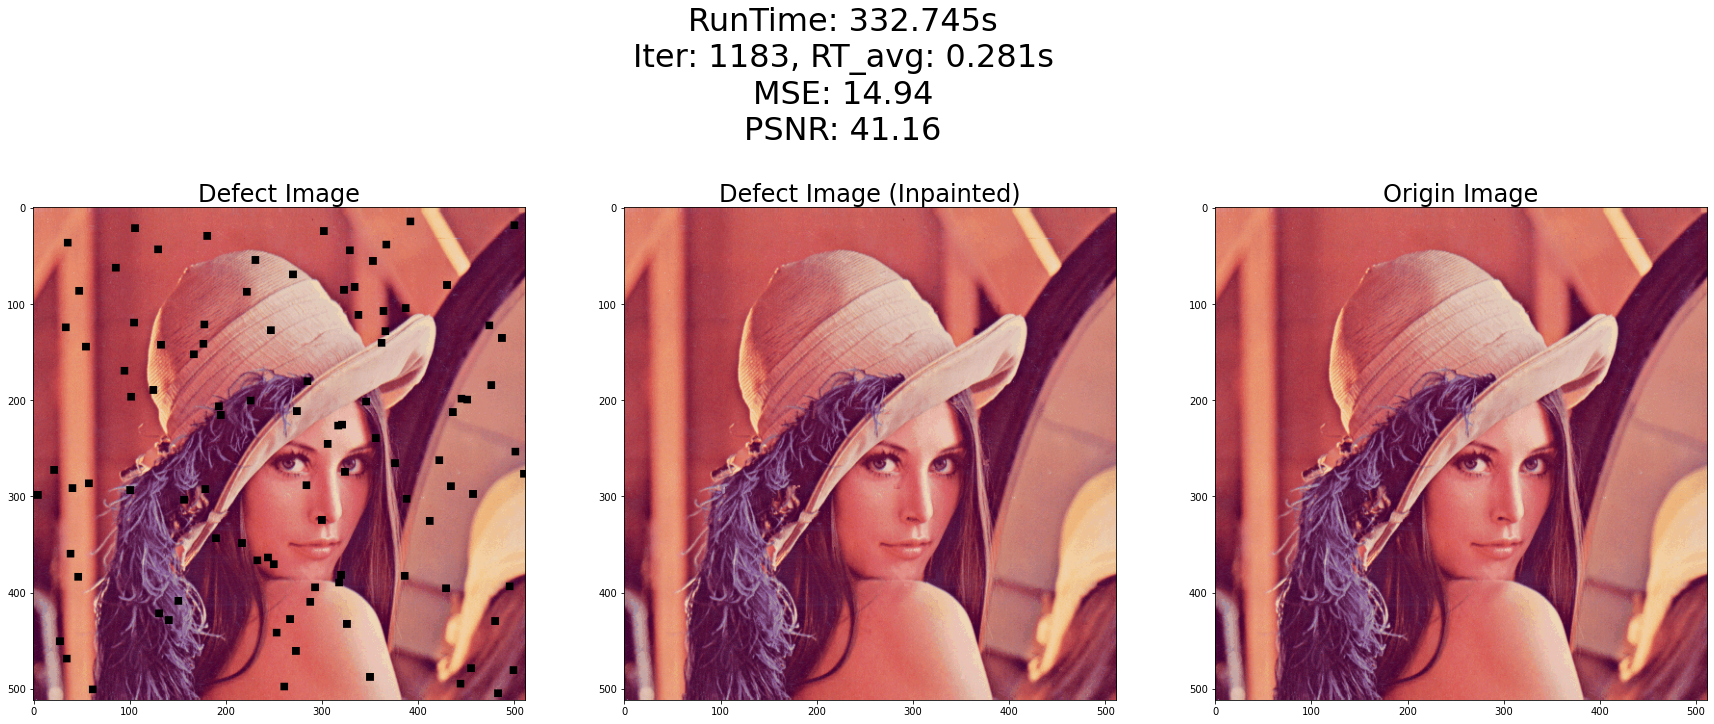

In [21]:
origin_image = cv2.imread(origin_path)
origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)

def mse(imageA, imageB):
	err = np.sum((imageA.astype("float64") - imageB.astype("float64")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	return err

fig, axs = plt.subplots(1, 3, figsize=(30, 13))
axs[0].imshow(image)
axs[0].set_title("Defect Image", fontsize=24)
axs[1].imshow(working_image)
axs[1].set_title("Defect Image (Inpainted)", fontsize=24)
axs[2].imshow(origin_image)
axs[2].set_title("Origin Image", fontsize=24)
fig.suptitle("RunTime: %.3fs\nIter: %d, RT_avg: %.3fs\nMSE: %.2f\nPSNR: %.2f" % (sum(timer), itera, sum(timer)/len(timer), mse(origin_image, working_image), cv2.PSNR(origin_image, working_image)), fontsize=32)
plt.show()
fig.savefig('./output/{}{}_{}x{}_cupy_inpaintedContrast.png'.format(file_name, file_secondName, patch_size[0], patch_size[1]), dpi=300)

In [19]:
anim = camera.animate()
f = r"{}{}_anim.mp4".format(file_name, file_secondName) 
anim.save("./output/{}{}_{}x{}_cupy_anim.mp4".format(file_name, file_secondName, patch_size[0], patch_size[1]) , writer = 'ffmpeg', fps=5)

In [ ]:
text = """
Iter: 1, sRuntime: 5.916895151138306, nowMask: 4767\nIter: 2, sRuntime: 1.8964760303497314, nowMask: 4763\nIter: 3, sRuntime: 1.253084421157837, nowMask: 4747\nIter: 4, sRuntime: 1.2793922424316406, nowMask: 4731\nIter: 5, sRuntime: 1.2441818714141846, nowMask: 4715\nIter: 6, sRuntime: 1.0776431560516357, nowMask: 4699\nIter: 7, sRuntime: 1.2427423000335693, nowMask: 4683\nIter: 8, sRuntime: 1.2283909320831299, nowMask: 4667\nIter: 9, sRuntime: 1.2259430885314941, nowMask: 4651\nIter: 10, sRuntime: 1.303227186203003, nowMask: 4635\nIter: 11, sRuntime: 1.1270689964294434, nowMask: 4619\nIter: 12, sRuntime: 1.320173740386963, nowMask: 4603\nIter: 13, sRuntime: 1.2383387088775635, nowMask: 4587\nIter: 14, sRuntime: 1.2382152080535889, nowMask: 4571\nIter: 15, sRuntime: 1.2437264919281006, nowMask: 4555\nIter: 16, sRuntime: 1.2418951988220215, nowMask: 4537\nIter: 17, sRuntime: 1.2292797565460205, nowMask: 4521\nIter: 18, sRuntime: 1.2293083667755127, nowMask: 4505\nIter: 19, sRuntime: 1.2399516105651855, nowMask: 4489\nIter: 20, sRuntime: 1.2403769493103027, nowMask: 4471\nIter: 21, sRuntime: 1.2336559295654297, nowMask: 4455\nIter: 22, sRuntime: 1.2306218147277832, nowMask: 4439\nIter: 23, sRuntime: 1.235497236251831, nowMask: 4423\nIter: 24, sRuntime: 1.2202987670898438, nowMask: 4407\nIter: 25, sRuntime: 1.2240886688232422, nowMask: 4391\nIter: 26, sRuntime: 1.2299823760986328, nowMask: 4372\nIter: 27, sRuntime: 1.2346971035003662, nowMask: 4359\nIter: 28, sRuntime: 1.2157776355743408, nowMask: 4343\nIter: 29, sRuntime: 1.2231335639953613, nowMask: 4327\nIter: 30, sRuntime: 1.0526914596557617, nowMask: 4311\nIter: 31, sRuntime: 1.2145628929138184, nowMask: 4295\nIter: 32, sRuntime: 1.2208282947540283, nowMask: 4279\nIter: 33, sRuntime: 1.2178807258605957, nowMask: 4263\nIter: 34, sRuntime: 1.2129828929901123, nowMask: 4247\nIter: 35, sRuntime: 1.2092950344085693, nowMask: 4231\nIter: 36, sRuntime: 1.2243826389312744, nowMask: 4215\nIter: 37, sRuntime: 1.221006155014038, nowMask: 4207\nIter: 38, sRuntime: 1.2216193675994873, nowMask: 4191\nIter: 39, sRuntime: 1.2242317199707031, nowMask: 4175\nIter: 40, sRuntime: 1.2133536338806152, nowMask: 4159\nIter: 41, sRuntime: 1.2248005867004395, nowMask: 4143\nIter: 42, sRuntime: 1.2128801345825195, nowMask: 4127\nIter: 43, sRuntime: 1.220210313796997, nowMask: 4111\nIter: 44, sRuntime: 1.211862325668335, nowMask: 4095\nIter: 45, sRuntime: 1.2133252620697021, nowMask: 4079\nIter: 46, sRuntime: 1.2195708751678467, nowMask: 4063\nIter: 47, sRuntime: 1.211862325668335, nowMask: 4047\nIter: 48, sRuntime: 1.2121975421905518, nowMask: 4031\nIter: 49, sRuntime: 1.2317137718200684, nowMask: 4015\nIter: 50, sRuntime: 1.208777666091919, nowMask: 3999\nIter: 51, sRuntime: 1.2179086208343506, nowMask: 3983\nIter: 52, sRuntime: 1.2090308666229248, nowMask: 3967\nIter: 53, sRuntime: 1.212409496307373, nowMask: 3951\nIter: 54, sRuntime: 1.388110876083374, nowMask: 3935\nIter: 55, sRuntime: 1.3206088542938232, nowMask: 3919\nIter: 56, sRuntime: 1.2319517135620117, nowMask: 3903\nIter: 57, sRuntime: 1.2157378196716309, nowMask: 3887\nIter: 58, sRuntime: 1.2060670852661133, nowMask: 3871\nIter: 59, sRuntime: 1.220745325088501, nowMask: 3855\nIter: 60, sRuntime: 1.2197825908660889, nowMask: 3839\nIter: 61, sRuntime: 1.2125399112701416, nowMask: 3823\nIter: 62, sRuntime: 1.2287406921386719, nowMask: 3807\nIter: 63, sRuntime: 1.2175877094268799, nowMask: 3791\nIter: 64, sRuntime: 1.197967290878296, nowMask: 3775\nIter: 65, sRuntime: 1.1873979568481445, nowMask: 3759\nIter: 66, sRuntime: 1.1921272277832031, nowMask: 3743\nIter: 67, sRuntime: 1.1900367736816406, nowMask: 3727\nIter: 68, sRuntime: 1.1922392845153809, nowMask: 3711\nIter: 69, sRuntime: 1.1895697116851807, nowMask: 3695\nIter: 70, sRuntime: 1.2127623558044434, nowMask: 3679\nIter: 71, sRuntime: 1.191361665725708, nowMask: 3663\nIter: 72, sRuntime: 1.1949360370635986, nowMask: 3647\nIter: 73, sRuntime: 1.02781343460083, nowMask: 3631\nIter: 74, sRuntime: 1.1897156238555908, nowMask: 3615\nIter: 75, sRuntime: 1.1848952770233154, nowMask: 3599\nIter: 76, sRuntime: 1.1868295669555664, nowMask: 3583\nIter: 77, sRuntime: 1.180363416671753, nowMask: 3567\nIter: 78, sRuntime: 1.1832568645477295, nowMask: 3551\nIter: 79, sRuntime: 1.1890342235565186, nowMask: 3535\nIter: 80, sRuntime: 1.1767165660858154, nowMask: 3519\nIter: 81, sRuntime: 1.1809067726135254, nowMask: 3503\nIter: 82, sRuntime: 1.185394287109375, nowMask: 3487\nIter: 83, sRuntime: 1.1827831268310547, nowMask: 3473\nIter: 84, sRuntime: 1.1831748485565186, nowMask: 3457\nIter: 85, sRuntime: 1.1927759647369385, nowMask: 3441\nIter: 86, sRuntime: 1.1792058944702148, nowMask: 3425\nIter: 87, sRuntime: 1.1937899589538574, nowMask: 3409\nIter: 88, sRuntime: 1.1740155220031738, nowMask: 3393\nIter: 89, sRuntime: 1.1770362854003906, nowMask: 3377\nIter: 90, sRuntime: 1.1708714962005615, nowMask: 3361\nIter: 91, sRuntime: 1.1628952026367188, nowMask: 3345\nIter: 92, sRuntime: 1.1755287647247314, nowMask: 3329\nIter: 93, sRuntime: 1.184274673461914, nowMask: 3313\nIter: 94, sRuntime: 1.171795129776001, nowMask: 3297\nIter: 95, sRuntime: 1.1860039234161377, nowMask: 3281\nIter: 96, sRuntime: 1.1641082763671875, nowMask: 3265\nIter: 97, sRuntime: 1.1699328422546387, nowMask: 3249\nIter: 98, sRuntime: 1.1577308177947998, nowMask: 3233\nIter: 99, sRuntime: 1.1678967475891113, nowMask: 3217\nIter: 100, sRuntime: 1.157423496246338, nowMask: 3201\nIter: 101, sRuntime: 1.1733956336975098, nowMask: 3185\nIter: 102, sRuntime: 1.1619515419006348, nowMask: 3169\nIter: 103, sRuntime: 1.1604621410369873, nowMask: 3153\nIter: 104, sRuntime: 1.1685316562652588, nowMask: 3137\nIter: 105, sRuntime: 1.1568567752838135, nowMask: 3121\nIter: 106, sRuntime: 1.1607728004455566, nowMask: 3105\nIter: 107, sRuntime: 1.1578760147094727, nowMask: 3089\nIter: 108, sRuntime: 1.1512489318847656, nowMask: 3073\nIter: 109, sRuntime: 1.153921365737915, nowMask: 3057\nIter: 110, sRuntime: 1.1547462940216064, nowMask: 3041\nIter: 111, sRuntime: 1.1579201221466064, nowMask: 3025\nIter: 112, sRuntime: 1.1626911163330078, nowMask: 3009\nIter: 113, sRuntime: 1.1750879287719727, nowMask: 2993\nIter: 114, sRuntime: 1.1724979877471924, nowMask: 2977\nIter: 115, sRuntime: 1.167585849761963, nowMask: 2961\nIter: 116, sRuntime: 1.1490411758422852, nowMask: 2945\nIter: 117, sRuntime: 0.9744577407836914, nowMask: 2929\nIter: 118, sRuntime: 1.1464500427246094, nowMask: 2913\nIter: 119, sRuntime: 1.1572365760803223, nowMask: 2897\nIter: 120, sRuntime: 1.1561081409454346, nowMask: 2881\nIter: 121, sRuntime: 1.1584079265594482, nowMask: 2865\nIter: 122, sRuntime: 1.1506924629211426, nowMask: 2849\nIter: 123, sRuntime: 1.1626653671264648, nowMask: 2833\nIter: 124, sRuntime: 1.157282829284668, nowMask: 2817\nIter: 125, sRuntime: 1.1563973426818848, nowMask: 2801\nIter: 126, sRuntime: 1.1593871116638184, nowMask: 2785\nIter: 127, sRuntime: 1.150815486907959, nowMask: 2769\nIter: 128, sRuntime: 1.1423282623291016, nowMask: 2753\nIter: 129, sRuntime: 1.1611409187316895, nowMask: 2737\nIter: 130, sRuntime: 1.1590461730957031, nowMask: 2719\nIter: 131, sRuntime: 1.1634094715118408, nowMask: 2705\nIter: 132, sRuntime: 1.1428484916687012, nowMask: 2689\nIter: 133, sRuntime: 1.1554784774780273, nowMask: 2673\nIter: 134, sRuntime: 1.1684889793395996, nowMask: 2657\nIter: 135, sRuntime: 1.2970547676086426, nowMask: 2641\nIter: 136, sRuntime: 1.2147514820098877, nowMask: 2625\nIter: 137, sRuntime: 1.2386858463287354, nowMask: 2609\nIter: 138, sRuntime: 1.2809360027313232, nowMask: 2593\nIter: 139, sRuntime: 1.0312480926513672, nowMask: 2577\nIter: 140, sRuntime: 1.1559782028198242, nowMask: 2561\nIter: 141, sRuntime: 1.142085313796997, nowMask: 2545\nIter: 142, sRuntime: 1.1412734985351562, nowMask: 2529\nIter: 143, sRuntime: 1.142425775527954, nowMask: 2513\nIter: 144, sRuntime: 1.1831200122833252, nowMask: 2497\nIter: 145, sRuntime: 1.1272914409637451, nowMask: 2481\nIter: 146, sRuntime: 1.1337120532989502, nowMask: 2465\nIter: 147, sRuntime: 1.1443572044372559, nowMask: 2449\nIter: 148, sRuntime: 1.180403709411621, nowMask: 2433\nIter: 149, sRuntime: 1.132948637008667, nowMask: 2417\nIter: 150, sRuntime: 1.1365931034088135, nowMask: 2401\nIter: 151, sRuntime: 1.135042667388916, nowMask: 2385\nIter: 152, sRuntime: 1.1316208839416504, nowMask: 2369\nIter: 153, sRuntime: 1.1296041011810303, nowMask: 2353\nIter: 154, sRuntime: 1.125892162322998, nowMask: 2337\nIter: 155, sRuntime: 1.1387660503387451, nowMask: 2321\nIter: 156, sRuntime: 1.1430974006652832, nowMask: 2305\nIter: 157, sRuntime: 1.1357872486114502, nowMask: 2287\nIter: 158, sRuntime: 1.125877857208252, nowMask: 2271\nIter: 159, sRuntime: 1.1189696788787842, nowMask: 2255\nIter: 160, sRuntime: 1.1267943382263184, nowMask: 2239\nIter: 161, sRuntime: 1.1587133407592773, nowMask: 2223\nIter: 162, sRuntime: 1.2119357585906982, nowMask: 2207\nIter: 163, sRuntime: 0.9519658088684082, nowMask: 2191\nIter: 164, sRuntime: 1.1395180225372314, nowMask: 2175\nIter: 165, sRuntime: 1.178750991821289, nowMask: 2167\nIter: 166, sRuntime: 1.1320135593414307, nowMask: 2151\nIter: 167, sRuntime: 1.1469762325286865, nowMask: 2135\nIter: 168, sRuntime: 1.1534717082977295, nowMask: 2119\nIter: 169, sRuntime: 1.1658427715301514, nowMask: 2103\nIter: 170, sRuntime: 1.1222097873687744, nowMask: 2087\nIter: 171, sRuntime: 1.1303560733795166, nowMask: 2071\nIter: 172, sRuntime: 1.122096061706543, nowMask: 2055\nIter: 173, sRuntime: 1.1276094913482666, nowMask: 2039\nIter: 174, sRuntime: 1.1342527866363525, nowMask: 2023\nIter: 175, sRuntime: 1.1349577903747559, nowMask: 2007\nIter: 176, sRuntime: 1.1265487670898438, nowMask: 1991\nIter: 177, sRuntime: 0.9407591819763184, nowMask: 1975\nIter: 178, sRuntime: 0.9484493732452393, nowMask: 1959\nIter: 179, sRuntime: 0.9474172592163086, nowMask: 1940\nIter: 180, sRuntime: 1.1232938766479492, nowMask: 1936\nIter: 181, sRuntime: 1.1189484596252441, nowMask: 1920\nIter: 182, sRuntime: 1.1167500019073486, nowMask: 1904\nIter: 183, sRuntime: 1.1274778842926025, nowMask: 1888\nIter: 184, sRuntime: 1.1248126029968262, nowMask: 1872\nIter: 185, sRuntime: 1.1136131286621094, nowMask: 1856\nIter: 186, sRuntime: 1.116058588027954, nowMask: 1840\nIter: 187, sRuntime: 1.122277021408081, nowMask: 1824\nIter: 188, sRuntime: 1.1237068176269531, nowMask: 1808\nIter: 189, sRuntime: 1.132727861404419, nowMask: 1792\nIter: 190, sRuntime: 1.1113171577453613, nowMask: 1776\nIter: 191, sRuntime: 1.1151039600372314, nowMask: 1760\nIter: 192, sRuntime: 1.116529941558838, nowMask: 1744\nIter: 193, sRuntime: 1.1201927661895752, nowMask: 1728\nIter: 194, sRuntime: 1.1178581714630127, nowMask: 1712\nIter: 195, sRuntime: 1.1627635955810547, nowMask: 1696\nIter: 196, sRuntime: 1.1311368942260742, nowMask: 1680\nIter: 197, sRuntime: 1.0938825607299805, nowMask: 1664\nIter: 198, sRuntime: 1.1022672653198242, nowMask: 1648\nIter: 199, sRuntime: 1.0990617275238037, nowMask: 1632\nIter: 200, sRuntime: 1.0945916175842285, nowMask: 1616\nIter: 201, sRuntime: 1.0944361686706543, nowMask: 1600\nIter: 202, sRuntime: 1.1015665531158447, nowMask: 1584\nIter: 203, sRuntime: 1.0905981063842773, nowMask: 1568\nIter: 204, sRuntime: 1.0892512798309326, nowMask: 1552\nIter: 205, sRuntime: 1.0906407833099365, nowMask: 1536\nIter: 206, sRuntime: 1.0982048511505127, nowMask: 1520\nIter: 207, sRuntime: 0.9175441265106201, nowMask: 1504\nIter: 208, sRuntime: 1.0923233032226562, nowMask: 1488\nIter: 209, sRuntime: 1.1022050380706787, nowMask: 1472\nIter: 210, sRuntime: 1.0895941257476807, nowMask: 1456\nIter: 211, sRuntime: 1.1014533042907715, nowMask: 1440\nIter: 212, sRuntime: 1.0985076427459717, nowMask: 1424\nIter: 213, sRuntime: 1.0821051597595215, nowMask: 1408\nIter: 214, sRuntime: 1.0791816711425781, nowMask: 1392\nIter: 215, sRuntime: 1.086369514465332, nowMask: 1376\nIter: 216, sRuntime: 1.0932178497314453, nowMask: 1360\nIter: 217, sRuntime: 1.0905859470367432, nowMask: 1344\nIter: 218, sRuntime: 1.0959997177124023, nowMask: 1328\nIter: 219, sRuntime: 1.1043479442596436, nowMask: 1312\nIter: 220, sRuntime: 1.12111234664917, nowMask: 1296\nIter: 221, sRuntime: 1.167388916015625, nowMask: 1280\nIter: 222, sRuntime: 1.1205265522003174, nowMask: 1264\nIter: 223, sRuntime: 1.0799038410186768, nowMask: 1248\nIter: 224, sRuntime: 1.0720782279968262, nowMask: 1232\nIter: 225, sRuntime: 1.0774121284484863, nowMask: 1216\nIter: 226, sRuntime: 1.0825066566467285, nowMask: 1200\nIter: 227, sRuntime: 1.0717806816101074, nowMask: 1184\nIter: 228, sRuntime: 1.0720422267913818, nowMask: 1168\nIter: 229, sRuntime: 1.0811865329742432, nowMask: 1152\nIter: 230, sRuntime: 1.0714137554168701, nowMask: 1136\nIter: 231, sRuntime: 0.8988265991210938, nowMask: 1120\nIter: 232, sRuntime: 1.0748023986816406, nowMask: 1104\nIter: 233, sRuntime: 1.0756723880767822, nowMask: 1088\nIter: 234, sRuntime: 0.9055979251861572, nowMask: 1072\nIter: 235, sRuntime: 1.0703918933868408, nowMask: 1056\nIter: 236, sRuntime: 1.0688409805297852, nowMask: 1040\nIter: 237, sRuntime: 1.0697832107543945, nowMask: 1024\nIter: 238, sRuntime: 1.066835880279541, nowMask: 1008\nIter: 239, sRuntime: 1.0740587711334229, nowMask: 992\nIter: 240, sRuntime: 1.062565803527832, nowMask: 976\nIter: 241, sRuntime: 1.0693914890289307, nowMask: 960\nIter: 242, sRuntime: 1.0634844303131104, nowMask: 944\nIter: 243, sRuntime: 1.066878080368042, nowMask: 928\nIter: 244, sRuntime: 1.063974142074585, nowMask: 912\nIter: 245, sRuntime: 1.0678703784942627, nowMask: 896\nIter: 246, sRuntime: 1.06209135055542, nowMask: 880\nIter: 247, sRuntime: 1.1101746559143066, nowMask: 864\nIter: 248, sRuntime: 1.071934461593628, nowMask: 848\nIter: 249, sRuntime: 1.0764801502227783, nowMask: 832\nIter: 250, sRuntime: 1.0612118244171143, nowMask: 816\nIter: 251, sRuntime: 1.0780069828033447, nowMask: 800\nIter: 252, sRuntime: 1.0657248497009277, nowMask: 780\nIter: 253, sRuntime: 1.0587501525878906, nowMask: 768\nIter: 254, sRuntime: 1.0638043880462646, nowMask: 752\nIter: 255, sRuntime: 1.0576786994934082, nowMask: 736\nIter: 256, sRuntime: 1.059187412261963, nowMask: 720\nIter: 257, sRuntime: 1.0563297271728516, nowMask: 704\nIter: 258, sRuntime: 1.0613071918487549, nowMask: 688\nIter: 259, sRuntime: 1.0532050132751465, nowMask: 672\nIter: 260, sRuntime: 0.8932981491088867, nowMask: 656\nIter: 261, sRuntime: 0.8785078525543213, nowMask: 640\nIter: 262, sRuntime: 1.05861496925354, nowMask: 624\nIter: 263, sRuntime: 1.057586669921875, nowMask: 608\nIter: 264, sRuntime: 1.0571763515472412, nowMask: 592\nIter: 265, sRuntime: 1.0454559326171875, nowMask: 576\nIter: 266, sRuntime: 1.052290439605713, nowMask: 560\nIter: 267, sRuntime: 1.0497190952301025, nowMask: 544\nIter: 268, sRuntime: 1.0459175109863281, nowMask: 528\nIter: 269, sRuntime: 1.0401792526245117, nowMask: 512\nIter: 270, sRuntime: 1.052241325378418, nowMask: 496\nIter: 271, sRuntime: 1.046158790588379, nowMask: 480\nIter: 272, sRuntime: 1.040752649307251, nowMask: 464\nIter: 273, sRuntime: 1.0487077236175537, nowMask: 448\nIter: 274, sRuntime: 1.0464632511138916, nowMask: 432\nIter: 275, sRuntime: 1.0465648174285889, nowMask: 416\nIter: 276, sRuntime: 1.0417754650115967, nowMask: 400\nIter: 277, sRuntime: 1.0492160320281982, nowMask: 384\nIter: 278, sRuntime: 1.0445284843444824, nowMask: 368\nIter: 279, sRuntime: 1.0462148189544678, nowMask: 352\nIter: 280, sRuntime: 1.0441977977752686, nowMask: 336\nIter: 281, sRuntime: 1.0428016185760498, nowMask: 320\nIter: 282, sRuntime: 1.044285535812378, nowMask: 304\nIter: 283, sRuntime: 1.053185224533081, nowMask: 288\nIter: 284, sRuntime: 1.0405018329620361, nowMask: 272\nIter: 285, sRuntime: 1.0565924644470215, nowMask: 256\nIter: 286, sRuntime: 1.1051743030548096, nowMask: 240\nIter: 287, sRuntime: 0.896265983581543, nowMask: 224\nIter: 288, sRuntime: 1.0399401187896729, nowMask: 208\nIter: 289, sRuntime: 1.0258285999298096, nowMask: 192\nIter: 290, sRuntime: 1.0292441844940186, nowMask: 176\nIter: 291, sRuntime: 1.0243041515350342, nowMask: 160\nIter: 292, sRuntime: 1.0214354991912842, nowMask: 144\nIter: 293, sRuntime: 1.0184409618377686, nowMask: 128\nIter: 294, sRuntime: 1.024367094039917, nowMask: 112\nIter: 295, sRuntime: 1.024836778640747, nowMask: 96\nIter: 296, sRuntime: 1.0315113067626953, nowMask: 80\nIter: 297, sRuntime: 0.8487339019775391, nowMask: 64\nIter: 298, sRuntime: 1.0183446407318115, nowMask: 48\nIter: 299, sRuntime: 1.0168876647949219, nowMask: 32\nIter: 300, sRuntime: 1.0105187892913818, nowMask: 16
"""
text

In [ ]:
sRuntime = text.split(",")[1::2]

In [ ]:
runtime = [t.split(": ")[1] for t in sRuntime]

In [ ]:
runtime = np.array(runtime).astype(np.float)

In [ ]:
np.average(runtime)